# Degrees of Change map

A climate anomaly is the difference of a future climate compared to the present climate. In climate change studies, temperature anomalies are more important than absolute temperature ([NOAA](https://www.ncdc.noaa.gov/monitoring-references/dyk/anomalies-vs-temperature)). A temperature anomaly is the difference from an average, or baseline, temperature. The baseline temperature is typically computed by averaging 30 or more years of temperature data. In this example we we will create maps that show maximum temperature anomaly between a baseline time period (1961-1990) and end of century (2070-2099) period using the following downscaled LOCA data:
- Annual averages of future projections from HadGEM2-ES model, RCP 4.5 scenario
- Annual averages of future projections from HadGEM2-ES model, RCP 8.5 scenario
- Annual averages of historical projections from HadGEM2-ES model

Import required python libraries. There are several python libraries for making maps. In this example we will use matplotlib basemap toolkit, which is a python library for plotting 2D data on maps.
> Basemap does not do any plotting on it’s own, but provides the facilities to transform coordinates to one of 25 different map projections (using the PROJ.4 C library). Matplotlib is then used to plot contours, images, vectors, lines or points in the transformed coordinates. Shoreline, river and political boundary datasets (from Generic Mapping Tools) are provided, along with methods for plotting them. The GEOS library is used internally to clip the coastline and polticial boundary features to the desired map projection region.

> [Matplotlib Basemap Toolkit](https://matplotlib.org/basemap/users/intro.html)

In [106]:
# A 'magic' command that displays plots inline inside the notebook as static images
%matplotlib inline

import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import osr, gdal
from PIL import Image
import math
from textwrap import wrap

### Define variables

To work with other models or climate variables (tasmax, tasmin, pr), modify the variable values in the cell below.

In [4]:
# Entry point of the Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Time periods
baselinePeriod = [1961, 1990]
futurePeriod = [2070, 2099]

### Define functions

In [5]:
def getUrl(climvar, model, scenario):
    url = api + '/series/' + '_'.join([climvar, 'year', model, scenario]) + '/'
    if (scenario == 'historical'):
        url += str(baselinePeriod[0]) + '-01-01/' + str(baselinePeriod[1]) + '-12-31/'
    else:
        url += str(futurePeriod[0]) + '-01-01/' + str(futurePeriod[1]) + '-12-31/'
    return url

def convertImageToArray(rstore):
    # Read image file
    im = Image.open(requests.get(rstore['image'], stream=True).raw)
     # Get nodata value
    nodata = rstore['nodata']
    # Create a numpy array from image 
    data = np.array(im)
    # Any calculations will be wrong if nodata values are not taken care of
    # Create a masked numpy array for making calculations without nodata values
    rasterArray = np.ma.masked_equal(data, nodata)
    return rasterArray

def getData(url):
    # Make request
    response = requests.get(url)
    array_list = []
    if response.ok:
        series = response.json()
        # Get a list of Raster Stores in Series
        rstores = series['results']
        for item in rstores:
            array_list.append(convertImageToArray(item))
        return array_list
    else:
        return None

### Get data for baseline time period and future projections



In [6]:
historical_modeled = getData(getUrl('tasmax', 'HadGEM2-ES', 'historical'))
rcp45_modeled = getData(getUrl('tasmax', 'HadGEM2-ES', 'rcp45'))
rcp85_modeled = getData(getUrl('tasmax', 'HadGEM2-ES', 'rcp85'))
print(rcp45_modeled) 

[masked_array(data =
 [[-- -- -- ..., 287.9548645019531 286.964599609375 289.38958740234375]
 [-- -- -- ..., 287.8526916503906 289.57391357421875 290.4110107421875]
 [-- -- -- ..., 288.8935852050781 290.4870910644531 290.8188781738281]
 ..., 
 [-- -- -- ..., 303.6064147949219 303.48480224609375 305.2071838378906]
 [-- -- -- ..., 304.3479919433594 304.5370178222656 305.3215637207031]
 [-- -- -- ..., 304.16796875 304.5145568847656 305.0677795410156]],
             mask =
 [[ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 ..., 
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]
 [ True  True  True ..., False False False]],
       fill_value = 1e+30)
, masked_array(data =
 [[-- -- -- ..., 288.95098876953125 287.9804382324219 290.4064025878906]
 [-- -- -- ..., 288.8445739746094 290.586181640625 291.44354248046875]
 [-- -- -- ..., 289.9046630859375 291.510009765625 291.8673

### Calculate baseline average (1961-1990) using modeled historical

In [8]:
# Create a new array by averaging list of arrays
historical_modeled_avg = np.ma.array(tuple(historical_modeled)).mean(axis=0)
print(historical_modeled_avg.min(), historical_modeled_avg.max())

# Convert degrees Kelvin to Fahrenheit
historical_modeled_avg_F = (historical_modeled_avg - 273.15) * 1.8000 + 32.00
print(historical_modeled_avg_F.min(), historical_modeled_avg_F.max())

276.554785156 305.222363281
38.1286132812 89.7302539063


### Calculate future average (2070-2099) using modeled projections for RCP4.5 and RCP8.5

In [9]:
# Create a new array by averaging list of arrays
rcp45_modeled_avg = np.ma.array(tuple(rcp45_modeled)).mean(axis=0)
print(rcp45_modeled_avg.min(), rcp45_modeled_avg.max())

# Convert degrees Kelvin to Fahrenheit
rcp45_modeled_avg_F = (rcp45_modeled_avg - 273.15) * 1.8000 + 32.00
print(rcp45_modeled_avg_F.min(), rcp45_modeled_avg_F.max())

280.633984375 309.174658203
45.471171875 96.8443847656


In [10]:
# Create a new array by averaging list of arrays
rcp85_modeled_avg = np.ma.array(tuple(rcp85_modeled)).mean(axis=0)
print(rcp85_modeled_avg.min(), rcp85_modeled_avg.max())

# Convert degrees Kelvin to Fahrenheit
rcp85_modeled_avg_F = (rcp85_modeled_avg - 273.15) * 1.8000 + 32.00
print(rcp85_modeled_avg_F.min(), rcp85_modeled_avg_F.max())

282.520556641 310.934179687
48.8670019531 100.011523438


### Calculate degrees of change

In [35]:
rcp45 = rcp45_modeled_avg - historical_modeled_avg
rcp45.min(), rcp45.max()

(2.0123046875000341, 5.2956787109374659)

In [40]:
rcp85 = rcp85_modeled_avg - historical_modeled_avg
rcp85.min(), rcp85.max()

(2.4934570312499886, 7.4812988281249773)

### Plot degrees of change maps

Create a list of values for binning the data

In [107]:
minVal = math.floor(rcp45.min())
maxVal = math.ceil(rcp85.max())
data_bins = list(range(minVal, maxVal + 1))
minVal, maxVal, data_bins

(2, 8, [2, 3, 4, 5, 6, 7, 8])

Get bounds of image. There are several ways to do this. For this exercise I opened one of the GeoTIFF files in QGIS and got the bounds from the metadata information.

In [244]:
(xmin, xmax, ymin, ymax) = (-124.5625, -113.375, 31.5625, 43.75)
print(xmin, xmax, ymin, ymax)

-124.5625 -113.375 31.5625 43.75


Define a function that takes two arguments - (1) axes to plot figure on, (2) data array and returns a map

In [245]:
# Projection used in California Albers (EPSG 3310)
def setup_map(ax, data):
    m = Basemap(resolution = 'l',
              #epsg = 3310,
              #projection='cyl',
              projection='merc', lat_0=0, 
              llcrnrlon = xmin, urcrnrlon = xmax,
              llcrnrlat = ymin, urcrnrlat = ymax,
              ax = ax
             )
    x = np.linspace(0, m.urcrnrx, data.shape[1])
    y = np.linspace(0, m.urcrnry, data.shape[0])

    xx, yy = np.meshgrid(x, y)
    cs = m.contourf(xx, yy, np.flipud(data), tuple(data_bins), cmap='YlOrRd')
    cbar = m.colorbar(cs ,location='bottom', pad="5%")
    cbar.set_label('Degree Celsius')
    
    # Draw other layers
    m.drawcounties()
    #m.readshapefile('data/cb_2016_us_county_500k', 'counties')
    return m

C:\ProgramData\Anaconda3\envs\caladapt\lib\site-packages\mpl_toolkits\basemap\__init__.py:3630: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\ProgramData\Anaconda3\envs\caladapt\lib\site-packages\mpl_toolkits\basemap\__init__.py:3699: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


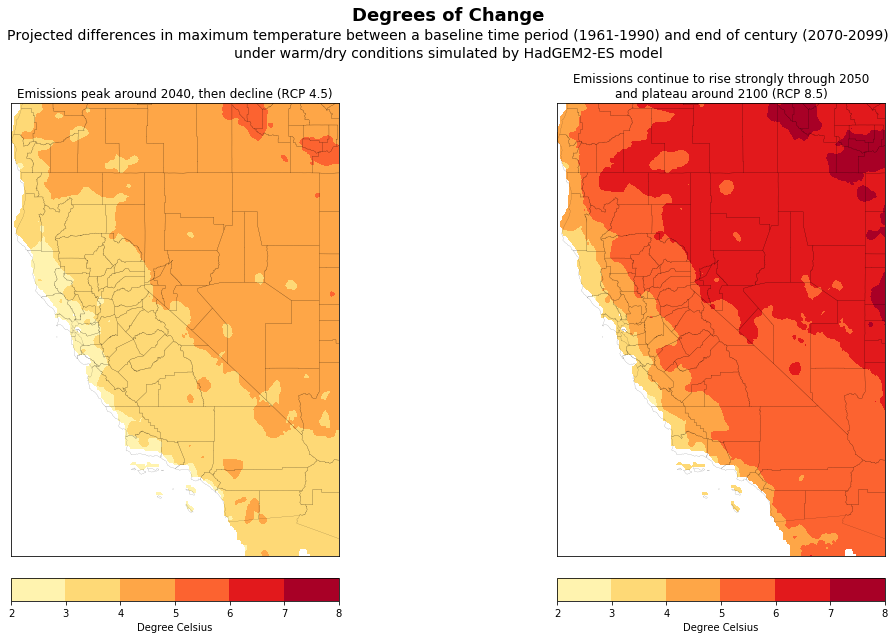

In [246]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].set_title('\n'.join(wrap('Emissions peak around 2040, then decline (RCP 4.5)', width=100)))
map1 = setup_map(ax[0], rcp45)

ax[1].set_title('\n'.join(wrap('Emissions continue to rise strongly through 2050 and plateau around 2100 (RCP 8.5)', width=50)))
map2 = setup_map(ax[1], rcp85)

plt.subplots_adjust(wspace=0, hspace=5)
plt.suptitle('Degrees of Change', fontsize=18, fontweight='bold', ha='center')
plt.tight_layout(pad=8, w_pad=0.5, h_pad=5)
desc_str1 = 'Projected differences in maximum temperature between a baseline time period (1961-1990) and end of century (2070-2099)'
desc_str2 = 'under warm/dry conditions simulated by HadGEM2-ES model';
plt.gcf().text(0.5, 0.935, desc_str1, fontsize=14, ha='center')
plt.gcf().text(0.5, 0.91, desc_str2, fontsize=14, ha='center')
plt.savefig('DegreesOfChange.png', dpi=150)
plt.show()

![End](image/border.png)

### Export raster to GeoTIFF file

This is an option section. If you want to export any new numpy arrays you calculated to a GeoTIFF file, you can modify the following code for your data.

#### 1. Get information about projection, spatial extent from one of the GeoTIFF files
The Python image library Pillow that we used earlier to read GeoTIFF files into numpy arrays discards any projection and geotransform metadata that is stored in GeoTIFF files (since it supports only TIFF files). GDAL is the most used open source Python library for reading/writing spatially aware rasters.

In [52]:
import gdal

In [250]:
# Read image file
imageFile = 'http://api.cal-adapt.org/media/img/tasmax_year_HadGEM2-ES_rcp45_r1i1p1_2006.LOCA_2016-04-02.16th.CA_NV.tif'
# Open file with gdal
ds = gdal.Open(imageFile)

# Geotransform and projection
gt = ds.GetGeoTransform()   
proj = ds.GetProjection()

# X, Y resolution
xres = gt[1]
yres = gt[5]

# Number of rows and columns
rows = ds.RasterXSize
cols = ds.RasterYSize

# Calculate bounds using geotransform, resolution, num. of rows and columns
xmin = gt[0] + xres
xmax = gt[0] + (xres * rows) - xres
ymin = gt[3] + (yres * cols) + yres
ymax = gt[3] - yres

print(proj)
print(gt)
(xmin, xmax, ymin, ymax)

ds = None

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
(-124.5625, 0.0625, 0.0, 43.75, 0.0, -0.0625)


#### 2. Export raster

In [252]:
outFileName = 'rcp45_DOC.tif'

driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, rows, cols, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(gt) # sets same geotransform as input
outdata.SetProjection(proj) # sets same projection as input
outdata.GetRasterBand(1).WriteArray(rcp45)
outdata.FlushCache() # saves to disk!!
outdata = None
ds = None